<a href="https://colab.research.google.com/github/hyacob-89/fake_news_detector/blob/ana%2Fwork/fake_news_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <u>__Dependencies__<u/>

In [0]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


In [0]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-05-19 23:21:45--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.05MB/s    in 0.8s    

2020-05-19 23:21:47 (1.05 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [0]:
# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()

In [0]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://news-detector-project.s3.us-east-2.amazonaws.com/FakeNews.csv"
spark.sparkContext.addFile(url)
df_fake = spark.read.csv(SparkFiles.get("FakeNews.csv"), sep=",", header=True)

# Show DataFrame
df_fake.show()

+--------------------+--------------------+--------------+-----------+
|               title|         articletext|articlesubject|articledate|
+--------------------+--------------------+--------------+-----------+
| Donald Trump Sen...|Donald Trump just...|          News|  31-Dec-17|
| Drunk Bragging T...|House Intelligenc...|          News|  31-Dec-17|
| Sheriff David Cl...|On Friday, it was...|          News|  30-Dec-17|
| Trump Is So Obse...|On Christmas day,...|          News|  29-Dec-17|
| Pope Francis Jus...|Pope Francis used...|          News|  25-Dec-17|
| Racist Alabama C...|The number of cas...|          News|  25-Dec-17|
| Fresh Off The Go...|Donald Trump spen...|          News|  23-Dec-17|
| Trump Said Some ...|In the wake of ye...|          News|  23-Dec-17|
| Former CIA Direc...|Many people have ...|          News|  22-Dec-17|
| WATCH: Brand-New...|Just when you mig...|          News|  21-Dec-17|
| Papa John’s Foun...|A centerpiece of ...|          News|  21-Dec-17|
| WATC

In [0]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://news-detector-project.s3.us-east-2.amazonaws.com/TrueNews.csv"
spark.sparkContext.addFile(url)
df_true = spark.read.csv(SparkFiles.get("TrueNews.csv"), sep=",", header=True)

# Show DataFrame
df_true.show()

+--------------------+--------------------+--------------------+------------+
|               title|         articletext|      articlesubject| articledate|
+--------------------+--------------------+--------------------+------------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|   31-Dec-17|
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|   29-Dec-17|
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|   31-Dec-17|
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|   30-Dec-17|
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|   29-Dec-17|
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|   29-Dec-17|
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|   29-Dec-17|
|Factbox: Trump on...|The following sta...|        politicsNews|   29-Dec-17|
|Trump on Twitter ...|The following sta...|        politicsNews|   29-Dec-17|
|Alabama official ...|WASHINGTON (Reute...|        politicsNews|

In [0]:
import pandas as pd
fake_df = df_fake.toPandas() 
fake_df.head()

,title,articletext,articlesubject,articledate
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17


In [0]:
true_df = df_true.toPandas() 
true_df.head()

,title,articletext,articlesubject,articledate
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17


In [0]:
fake_df['label'] = 1
fake_df.head()

,title,articletext,articlesubject,articledate,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,31-Dec-17,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,31-Dec-17,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,30-Dec-17,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,29-Dec-17,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,25-Dec-17,1


In [0]:
true_df['label'] = 0
true_df.head()

,title,articletext,articlesubject,articledate,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17,0


In [29]:
df2 = pd.concat([fake_df[['articletext','articlesubject', 'label']], true_df[['articletext','articlesubject', 'label']]], axis=0)

#Reset the index
# df1 = df1.set_index(inplace=True)

# r
df2.head()

,articletext,articlesubject,label
0,Donald Trump just couldn t wish all Americans ...,News,1
1,House Intelligence Committee Chairman Devin Nu...,News,1
2,"On Friday, it was revealed that former Milwauk...",News,1
3,"On Christmas day, Donald Trump announced that ...",News,1
4,Pope Francis used his annual Christmas Day mes...,News,1


In [0]:
def clean_data_text(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='articletext', inplace=True)
    
    # Remove punctation
    dataframe['articletext'] = dataframe['articletext'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['articletext'] = dataframe['articletext'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['articletext'] = dataframe['articletext'].str.replace('  ',' ')
    dataframe['articletext'] = dataframe['articletext'].str.replace('  ',' ')

    # # Transform all text to lowercase
    dataframe['articletext'] = dataframe['articletext'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [30]:
# Call `clean_data_text(dataframe)` function
clean_data_text(df2)


New shape: (38628, 3)


,articletext,articlesubject,label
0,donald trump just couldn t wish all americans ...,News,1
1,house intelligence committee chairman devin nu...,News,1
2,on friday it was revealed that former milwauke...,News,1
3,on christmas day donald trump announced that h...,News,1
4,pope francis used his annual christmas day mes...,News,1


In [31]:
df2 = df2[df2.articletext.isna() == False]
l =len(df2)
print('rows after removing nans: ', l)
rando = list(np.random.choice(l-2, 4001, replace=True))
df2 =df2.iloc[rando]

rows after removing nans:  38627


In [32]:
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4001 entries, 2715 to 13024
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   articletext     4001 non-null   object
 1   articlesubject  4001 non-null   object
 2   label           4001 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 125.0+ KB


In [33]:
print("Shape:", df2.shape)


Shape: (4001, 3)


## <u>__Data Analysis__<u/>

In [0]:
# define function for graphs
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

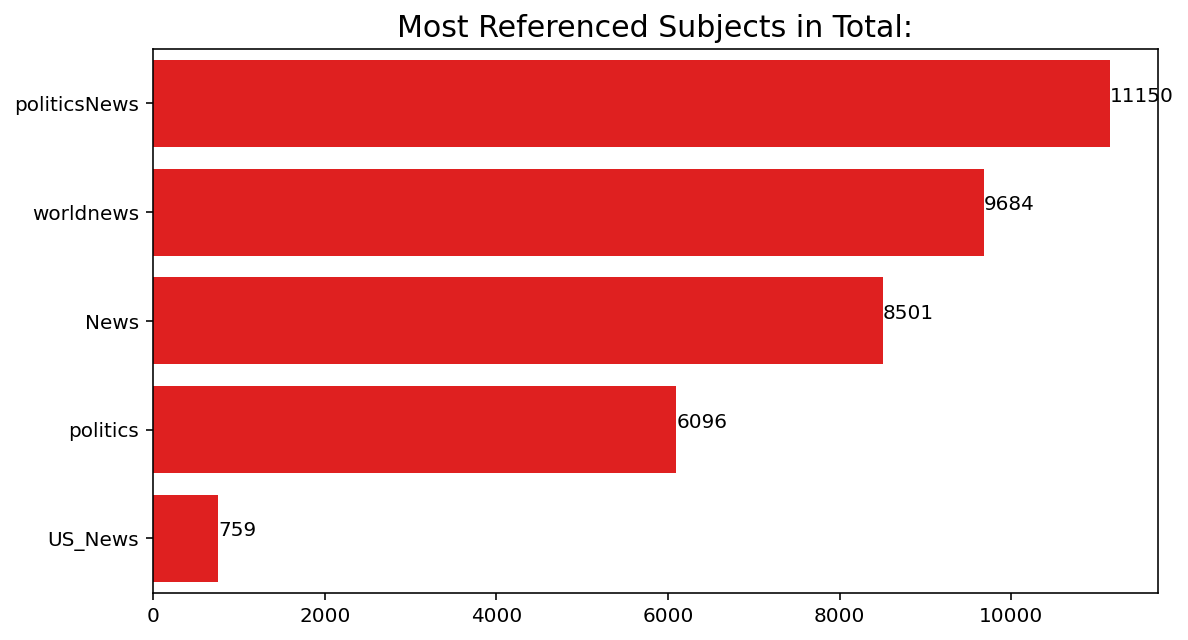

In [35]:
# Set x values: # of posts for both datasets
df_domain = df1['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'Most Referenced Subjects in Total:' ,'r')

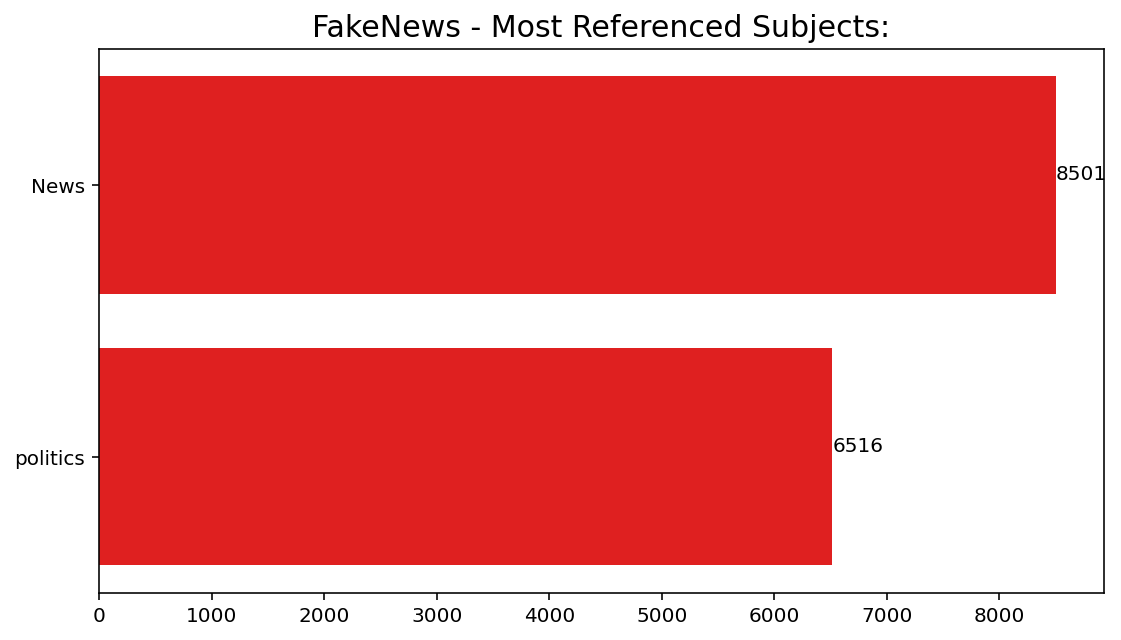

In [36]:
# Set x values: # of posts fake df
df_domain = fake_df['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(2)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'FakeNews - Most Referenced Subjects:' ,'r')

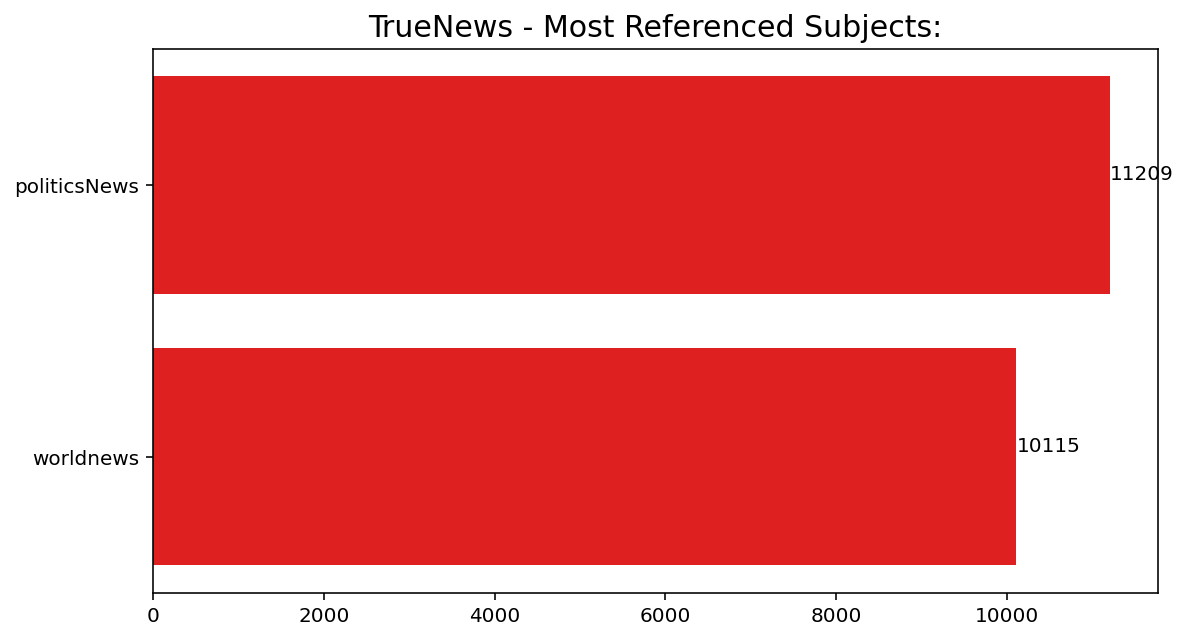

In [37]:
# Set x values: # of posts for true df
df_domain = true_df['articlesubject'].value_counts() 
df_domain = df_domain.sort_values(ascending=False).head(2)

# Set y values: Domains 
df_domain_index = list(df_domain.index)

# Call function
bar_plot(df_domain.values, df_domain_index, 'TrueNews - Most Referenced Subjects:' ,'r')

**-CountVectorizer()**

*   Count Vectorize df1 where 'label' is 1
*   ngram_range = (1,1)



In [39]:
# Set variables to show Fake Titles
mask_on = df2['label'] == 1
df_news_titles = df2[mask_on]['articletext']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
news_cvec = cv1.fit_transform(df_news_titles)

# Convert onion_cvec into a DataFrame
news_cvec_df = pd.DataFrame(news_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of fake Titles cvec
print(news_cvec_df.shape)
# print(onion_cvec_df)

(1800, 27784)



-**Apply CountVectorizer()**
   *   Vectorize df where 'label' is 0
   *   ngram_range = (1,1)



In [41]:
mask_no = df2['label'] == 0
df_not_news_titles = df2[mask_no]['articletext']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_news_cvec = cv2.fit_transform(df_not_news_titles)

# Convert news_cvec into a DataFrame
not_news_cvec_df = pd.DataFrame(not_news_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not News Titles cvec
print(not_news_cvec_df.shape)

(2201, 25542)


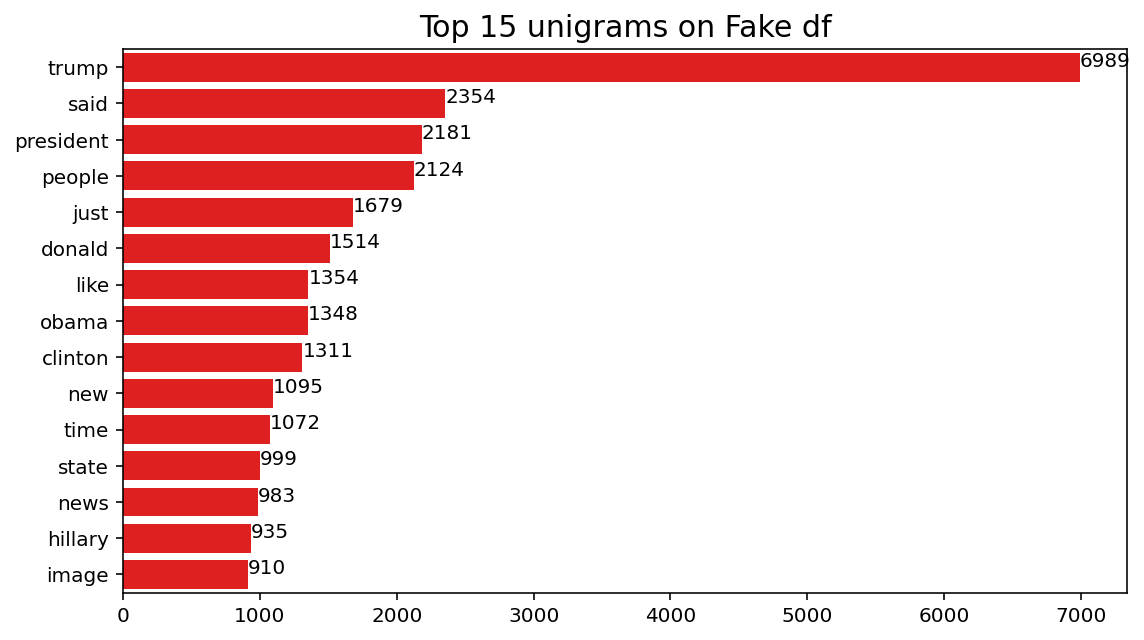

In [42]:
# Set up variables to contain top 15 most used words in Fake df
news_wc = news_cvec_df.sum(axis = 0)
news_top_5 = news_wc.sort_values(ascending=False).head(15)

# Call function
bar_plot(news_top_5.values, news_top_5.index, 'Top 15 unigrams on Fake df','r')

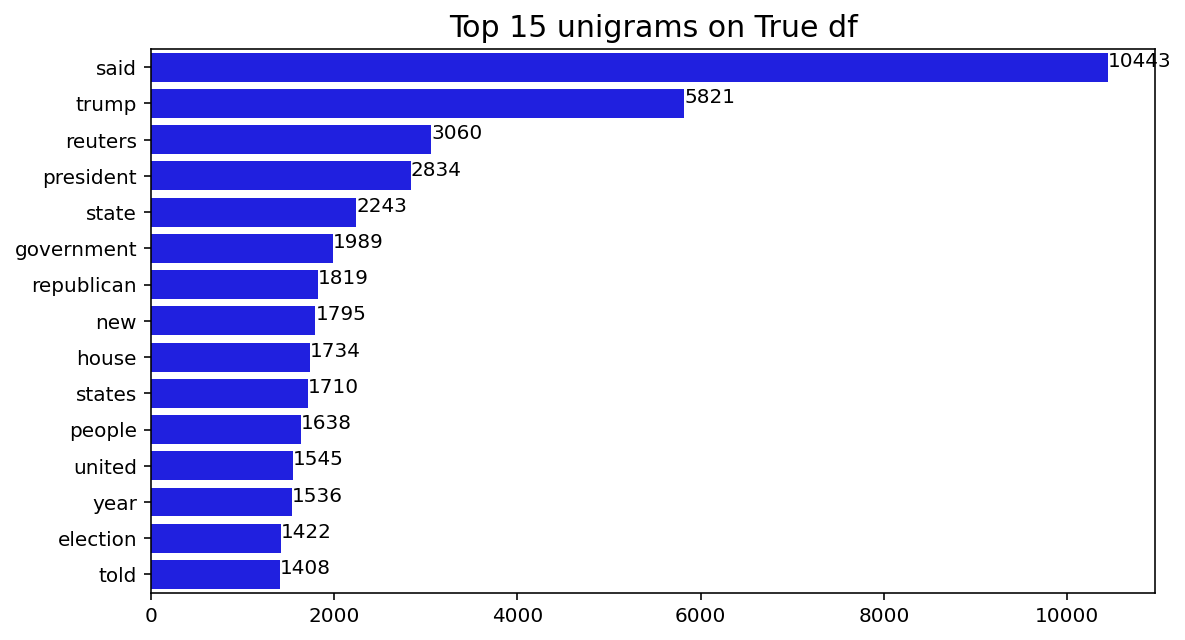

In [43]:
# Set up variables to contain top 15 most used words in Onion
nnews_wc = not_news_cvec_df.sum(axis = 0)
nnews_top_5 = nnews_wc.sort_values(ascending=False).head(15)

# Call function
bar_plot(nnews_top_5.values, nnews_top_5.index, 'Top 15 unigrams on True df','b')

In [44]:
# Create list of unique words in top five
not_news_5_set = set(nnews_top_5.index)
news_5_set = set(news_top_5.index)

# Return common words
common_unigrams = news_5_set.intersection(not_news_5_set)
common_unigrams

{'new', 'people', 'president', 'said', 'state', 'trump'}

**-Apply CountVectorize** 
*   Count Vectorize df where "label" is 1
*   ngram_range = (2,2)




In [45]:
# Set variables to show Fake Titles
mask = df2['label'] == 1
df_news_titles = df2[mask]['articletext']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
news_cvec = cv.fit_transform(df_news_titles)

# Convert news_cvec into a DataFrame
news_cvec_df = pd.DataFrame(news_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Fake Titles cvec
print(news_cvec_df.shape)

(1800, 271831)


***- Apply CountVectorize ***
  *   Count Vectorize df where subreddit is 0
  *   ngram_range = (2,2) 

```
# This is formatted as code
```





In [46]:
# Set variables to show True Titles
mask = df2['label'] == 0
df_not_news_titles = df2[mask]['articletext']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_news_cvec = cv.fit_transform(df_not_news_titles)

# Convert onion_cvec into a DataFrame
not_news_cvec_df = pd.DataFrame(not_news_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of  True Titles cvec
print(not_news_cvec_df.shape)

(2201, 306954)


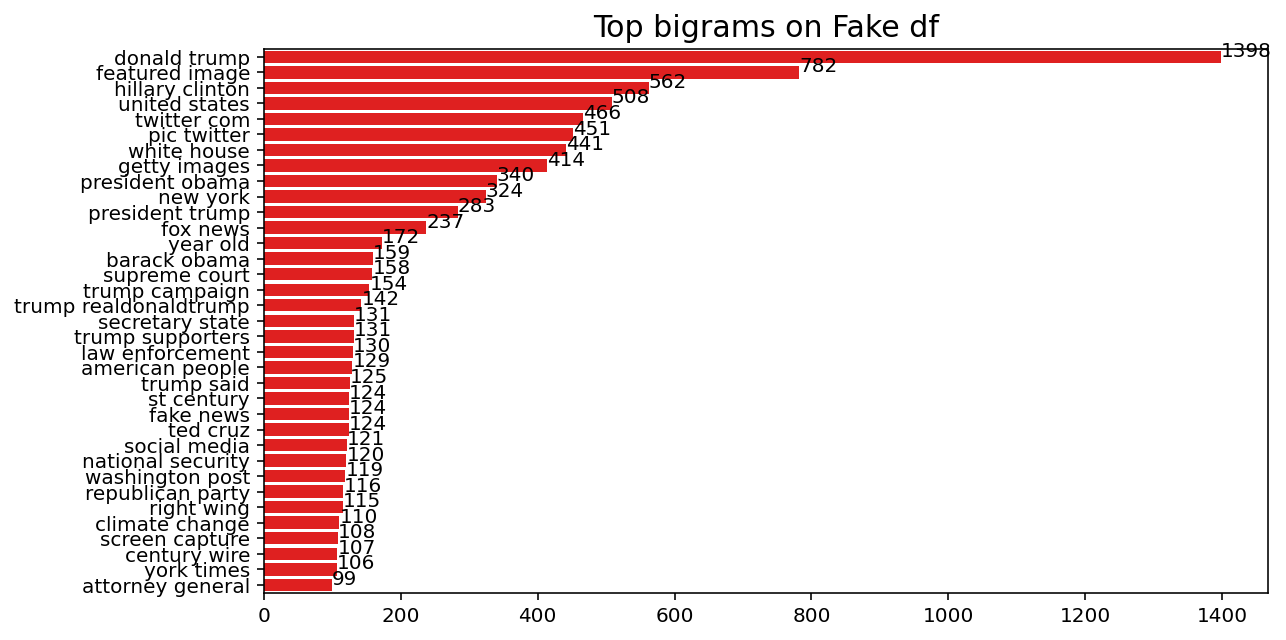

In [47]:
# Set up variables to contain top  most used bigrams in Fake df
news_wc = news_cvec_df.sum(axis = 0)
news_top_5 = news_wc.sort_values(ascending=False).head(35)

# Call function
bar_plot(news_top_5.values, news_top_5.index, 'Top bigrams on Fake df','r')

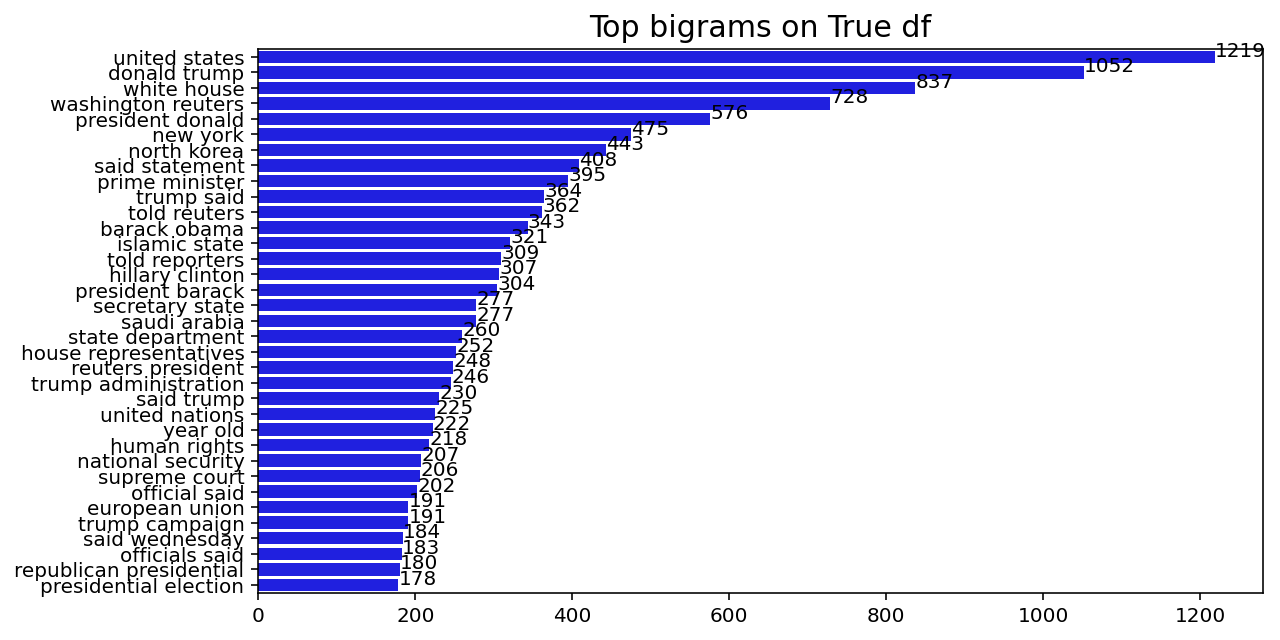

In [48]:
# Set up variables to contain top  most used bigrams in r/nottheonion
nnews_wc = not_news_cvec_df.sum(axis = 0)
nnews_top_5 = nnews_wc.sort_values(ascending=False).head(35)

# Call function
bar_plot(nnews_top_5.values, nnews_top_5.index, 'Top bigrams on True df','b')

In [50]:
not_news_5_list = set(nnews_top_5.index)
news_5_list = set(news_top_5.index)

# Return common words
common_bigrams = news_5_list.intersection(not_news_5_list)
common_bigrams

{'barack obama',
 'donald trump',
 'hillary clinton',
 'national security',
 'new york',
 'secretary state',
 'supreme court',
 'trump campaign',
 'trump said',
 'united states',
 'white house',
 'year old'}

Take out {'barack obama','donald trump','hillary clinton','new york','secretary state','supreme court','trump administration','trump said','united states','white house','year old'} from dataset when modeling, since these words occur frequently in both subreddits.

Create custom stop_words to include common frequent words
Referencing the common most-used words, add them to a customized stop_words list.

In [0]:
from sklearn.feature_extraction import stop_words
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

####Here I conduct model-prep and use Pipeline and 

1.   List item
2.   List item

GridSearch to determine the most optimal model to run my data on.


In [52]:
#Baseline Score
df1['label'].value_counts(normalize=True)

0    0.545559
1    0.454441
Name: label, dtype: float64

####'I expect my model to be better than 54%. The majority class is 0, or, True. If the model is not better than 54%, I know the model is not performing well.'


In [0]:
#Set X (predictor) and y (target) variables
X = df2['articletext']
y = df2['label']

In [0]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

**Model 1**: *CountVectorizer & Logistic Regression*

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix


pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.9863333333333334
Train score 1.0
Test score 0.991008991008991


{'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ['after',
  'twenty',
  'over',
  'behind',
  'always',
  'else',
  'hasnt',
  'bottom',
  'latterly',
  'before',
  'next',
  'only',
  'this',
  'if',
  'ltd',
  'most',
  'must',
  'which',
  'because',
  'down',
  'couldnt',
  'give',
  'might',
  'seemed',
  'as',
  'beyond',
  'whereafter',
  'part',
  'whereby',
  'becomes',
  'what',
  'for',
  'eleven',
  'show',
  'anyway',
  'ie',
  'bill',
  'between',
  'i',
  'anything',
  'however',
  'am',
  'them',
  'has',
  'myself',
  'whereas',
  'can',
  'five',
  'towards',
  'whatever',
  'nine',
  'toward',
  'go',
  'while',
  'amongst',
  'seem',
  'cannot',
  'will',
  'those',
  'from',
  'side',
  'nevertheless',
  'same',
  'together',
  'their',
  'an',
  'himself',
  'until',
  'or',
  'becoming',
  'serious',
  'whoever',
  'almost',
  'perhaps',
  'nothing',
  'per',
  'him',
  'anyone',
  'eg',
  'thereafter',
  'name',
  'us',
  'any',
  'no',
  'either',
  'get',
 

####while the model is overfit, I am optimizing to get the highest accuracy score in my test set

**Model 3: CountVectorizer & MultinomialNB**

In [0]:
# pipe = Pipeline([('cvec', CountVectorizer()),    
#                  ('nb', MultinomialNB())])

# # Tune GridSearchCV
# pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
#                'nb__alpha': [.36, .6]}

# gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
# gs.fit(X_train, y_train);
# print("Best score:", gs.best_score_)
# print("Train score", gs.score(X_train, y_train))
# print("Test score", gs.score(X_test, y_test))

# gs.best_params_

**##CountVectorizer & MultinomialNB**

In [0]:
# #Instantiate the classifier and vectorizer
# nb = MultinomialNB(alpha = 0.36)
# cvec = CountVectorizer(ngram_range= (1, 3))

# # Fit and transform the vectorizor
# cvec.fit(X_train)

# Xcvec_train = cvec.transform(X_train)
# Xcvec_test = cvec.transform(X_test)

# # Fit the classifier
# nb.fit(Xcvec_train,y_train)

# # Create the predictions for Y training data
# preds = nb.predict(Xcvec_test)

# print(nb.score(Xcvec_test, y_test))

In [0]:
# Customize stop_words to include `onion` so that it doesn't appear
# in coefficients 

stop_words_onion = stop_words.ENGLISH_STOP_WORDS
stop_words_onion = list(stop_words_onion)
stop_words_onion.append('onion')


In [65]:
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = stop_words_onion)

# Fit and transform the vectorizor
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.984015984015984


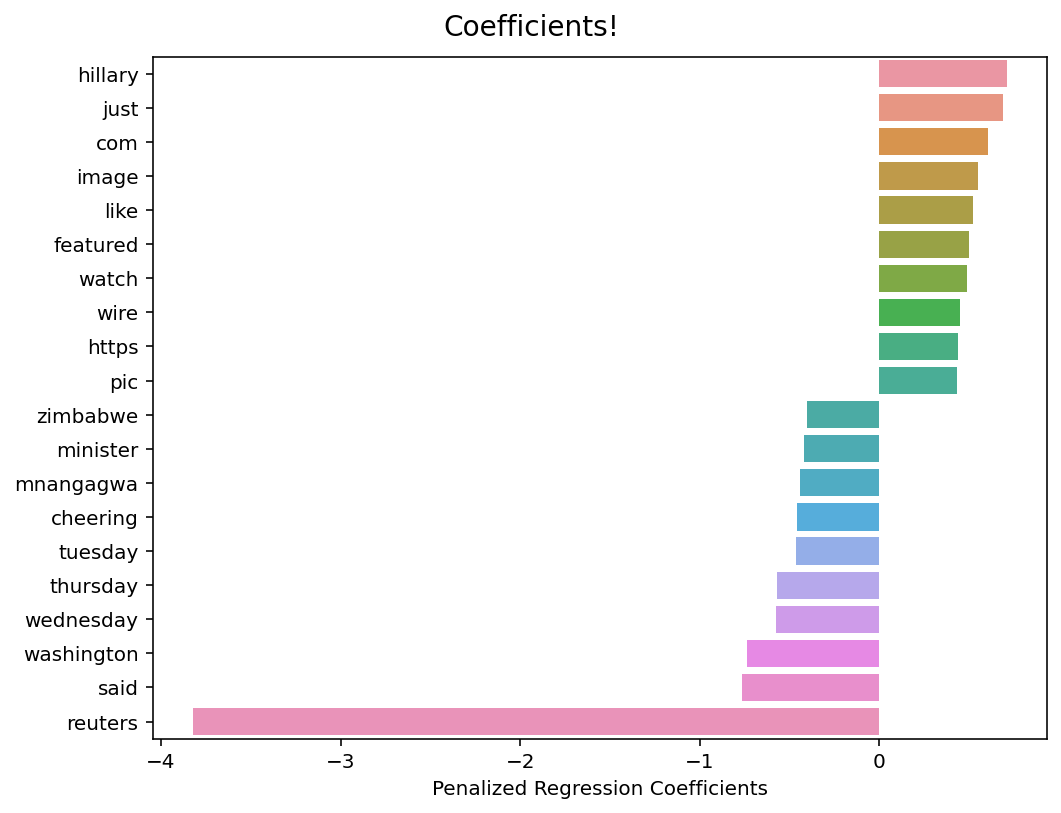

In [66]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [69]:
print("The word that contributes the most positively to being from Fake.csv is", 
     '"', df_merged.index[0],'"', "followed by", 
      '"',df_merged.index[1],"'", "and",
      '"',df_merged.index[2],'"',".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion is", 
      '"',df_merged.index[-1],'"', "followed by", 
      '"',df_merged.index[-2],'"', "and",
      '"',df_merged.index[-3],'"',".")

The word that contributes the most positively to being from Fake.csv is " hillary " followed by " just ' and " com " .
-----------------------------------
The word that contributes the most positively to being from r/nottheonion is " reuters " followed by " said " and " washington " .


In [70]:
# Show coefficients that affect Fake csv
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
hillary,0.708,2.029927
just,0.688,1.989732
com,0.607,1.834918
image,0.550,1.733253
like,0.520,1.682028
featured,0.497,1.643783
watch,0.486,1.625800
wire,0.451,1.569881
https,0.436,1.546509
pic,0.431,1.538796


In [71]:
print("As occurences of",'"', df_merged_head.index[0],'"', "increase by 1 in an article, that article is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as fake.")

As occurences of " hillary " increase by 1 in an article, that article is 2.03 times as likely to be classified as fake.


In [73]:
# Show coefficients that affect r/nottheonion
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
reuters,-3.820,45.604208
said,-0.766,2.151144
washington,-0.735,2.085482
wednesday,-0.577,1.780688
thursday,-0.568,1.764734
tuesday,-0.465,1.592014
cheering,-0.460,1.584074
mnangagwa,-0.442,1.555816
minister,-0.418,1.518921
zimbabwe,-0.401,1.493317


In [74]:
print("As occurences of",'"', df_merged_tail.index[-1],'"', "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as true.")

As occurences of " reuters " increase by 1 in a title, that title is 45.6 times as likely to be classified as true.
